# Demo interacting with CRESST S3 Bucket 

"Object storage" like AWS S3 provides a great way to share scientific data. This notebook illustrates interacting with the S3 bucket for CRESST. 

Consider using a Cloud-optimized data format if you're adding data to S3 https://guide.cloudnativegeo.org 

We recommend using the Obstore library to interact with the bucket https://github.com/developmentseed/obstore 

Or if you want to upload an existing folder of data `aws s3 sync` is your friend https://docs.aws.amazon.com/cli/latest/reference/s3/sync.html

In [ ]:
import obstore
import boto3
import xarray as xr
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Upload derived data 

There are many workflows where you access private or public data and run computations or change to a format needed for downstream analysis. For example, we'll open a NISAR Soil Moisture Product but extract just one product from a larger file, and change the format from HDF5 to Cloud-optimized Geotiff

In [2]:
# This requires a ~/.netrc with NASA Earthdata credentials
url = 'https://nisar.asf.earthdatacloud.nasa.gov/NISAR/NISAR_L3_SME2_BETA_V1/NISAR_L3_PR_SME2_008_007_D_073_4005_DHDH_A_20251216T164223_20251216T164300_X05007_N_F_J_001/NISAR_L3_PR_SME2_008_007_D_073_4005_DHDH_A_20251216T164223_20251216T164300_X05007_N_F_J_001.h5'
!wget -nc {url}

File ‘NISAR_L3_PR_SME2_008_007_D_073_4005_DHDH_A_20251216T164223_20251216T164300_X05007_N_F_J_001.h5’ already there; not retrieving.



In [3]:
filename = url.split('/')[-1]
dt = xr.open_datatree(filename, engine='h5netcdf')
dt.groups

/var/folders/1v/k85p3x5d10zb9mhqx88lb3240000gn/T/ipykernel_69090/139391478.py:2: UserWarning: The 'phony_dims' kwarg now defaults to 'access'. Previously 'phony_dims=None' would raise an error. For full netcdf equivalence please use phony_dims='sort'.
  dt = xr.open_datatree(filename, engine='h5netcdf')


('/',
 '/science',
 '/science/LSAR',
 '/science/LSAR/SME2',
 '/science/LSAR/identification',
 '/science/LSAR/SME2/grids',
 '/science/LSAR/SME2/metadata',
 '/science/LSAR/SME2/grids/algorithmCandidates',
 '/science/LSAR/SME2/grids/ancillaryData',
 '/science/LSAR/SME2/grids/radarData',
 '/science/LSAR/SME2/metadata/processingInformation',
 '/science/LSAR/SME2/metadata/sourceData',
 '/science/LSAR/SME2/grids/algorithmCandidates/DSG',
 '/science/LSAR/SME2/grids/algorithmCandidates/PMI',
 '/science/LSAR/SME2/grids/algorithmCandidates/TSR',
 '/science/LSAR/SME2/grids/radarData/frequencyA',
 '/science/LSAR/SME2/grids/radarData/frequencyB',
 '/science/LSAR/SME2/metadata/processingInformation/algorithms',
 '/science/LSAR/SME2/metadata/processingInformation/inputs',
 '/science/LSAR/SME2/metadata/processingInformation/parameters',
 '/science/LSAR/SME2/metadata/sourceData/processingInformation',
 '/science/LSAR/SME2/metadata/sourceData/processingInformation/algorithms')

In [10]:
# Load a single Soil Moisture estimate rasterio/GDAL to get projection info
# Drops phonydim scalar variables, but does pick up CRS
algorithm = 'DSG'
group = f'/science/LSAR/SME2/grids/algorithmCandidates/{algorithm}'
ds = xr.open_dataset(f'NETCDF:{filename}',
                      group=group,
                      engine='rasterio').squeeze()
ds

<xarray.Dataset> Size: 66MB
Dimensions:                  (x: 1845, y: 1800)
Coordinates:
  * x                        (x) float64 15kB 2.784e+06 2.784e+06 ... 3.153e+06
  * y                        (y) float64 14kB 3.909e+06 3.909e+06 ... 3.549e+06
    band                     int64 8B 1
    projection               int64 8B ...
Data variables:
    algorithmParameterBeta   (y, x) float32 13MB ...
    algorithmParameterGamma  (y, x) float32 13MB ...
    retrievalQualityFlag     (y, x) float32 13MB ...
    soilMoisture             (y, x) float32 13MB ...
    soilMoistureUncertainty  (y, x) float32 13MB ...
Attributes:
    long_name:           200m soil moisture at EASE-Grid 2.0 projection
    contact:             nisar-sds-ops@jpl.nasa.gov
    Conventions:         CF-1.7
    institution:         NASA JPL
    mission_name:        NISAR
    reference_document:  D-107677 NISAR NASA SDS Product Specification Level-...
    title:               NISAR L3 SME2 Product

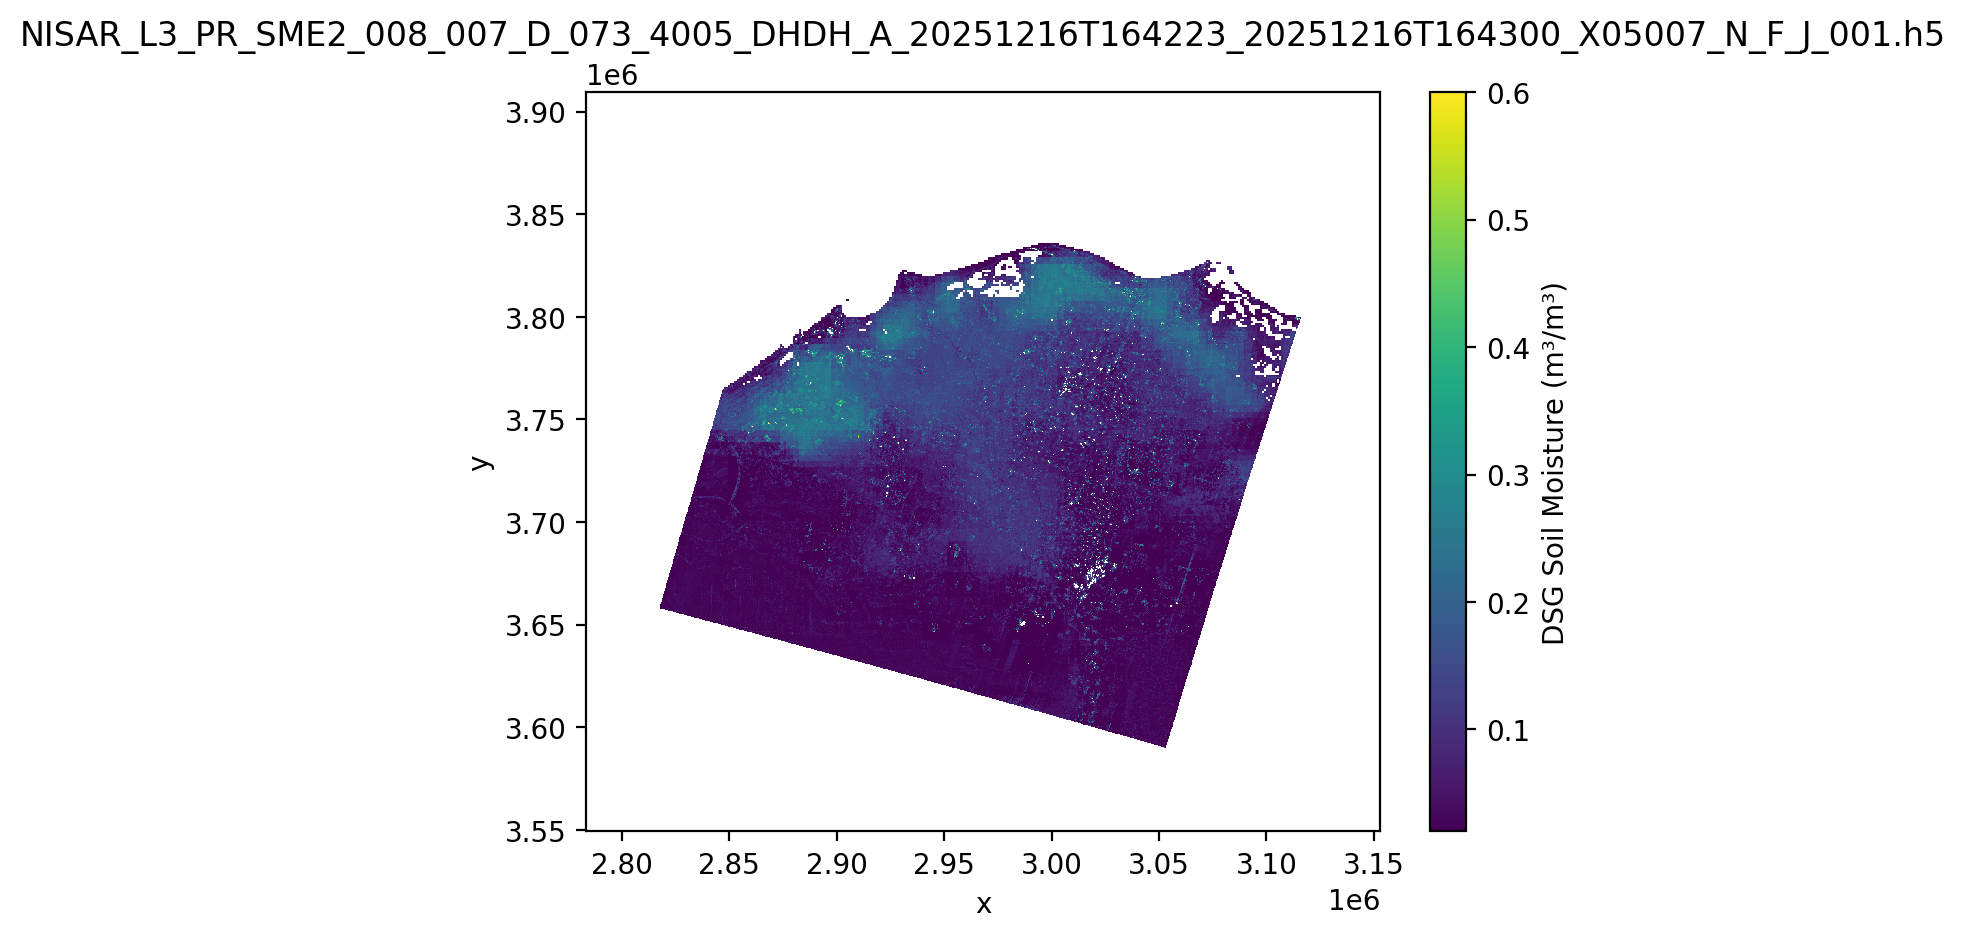

In [ ]:
# Basic plot
da = ds['soilMoisture']
da.plot.imshow(cbar_kwargs={'label': f'{algorithm} Soil Moisture (m³/m³)'})
plt.title(filename);

In [17]:
da.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6933"]]')

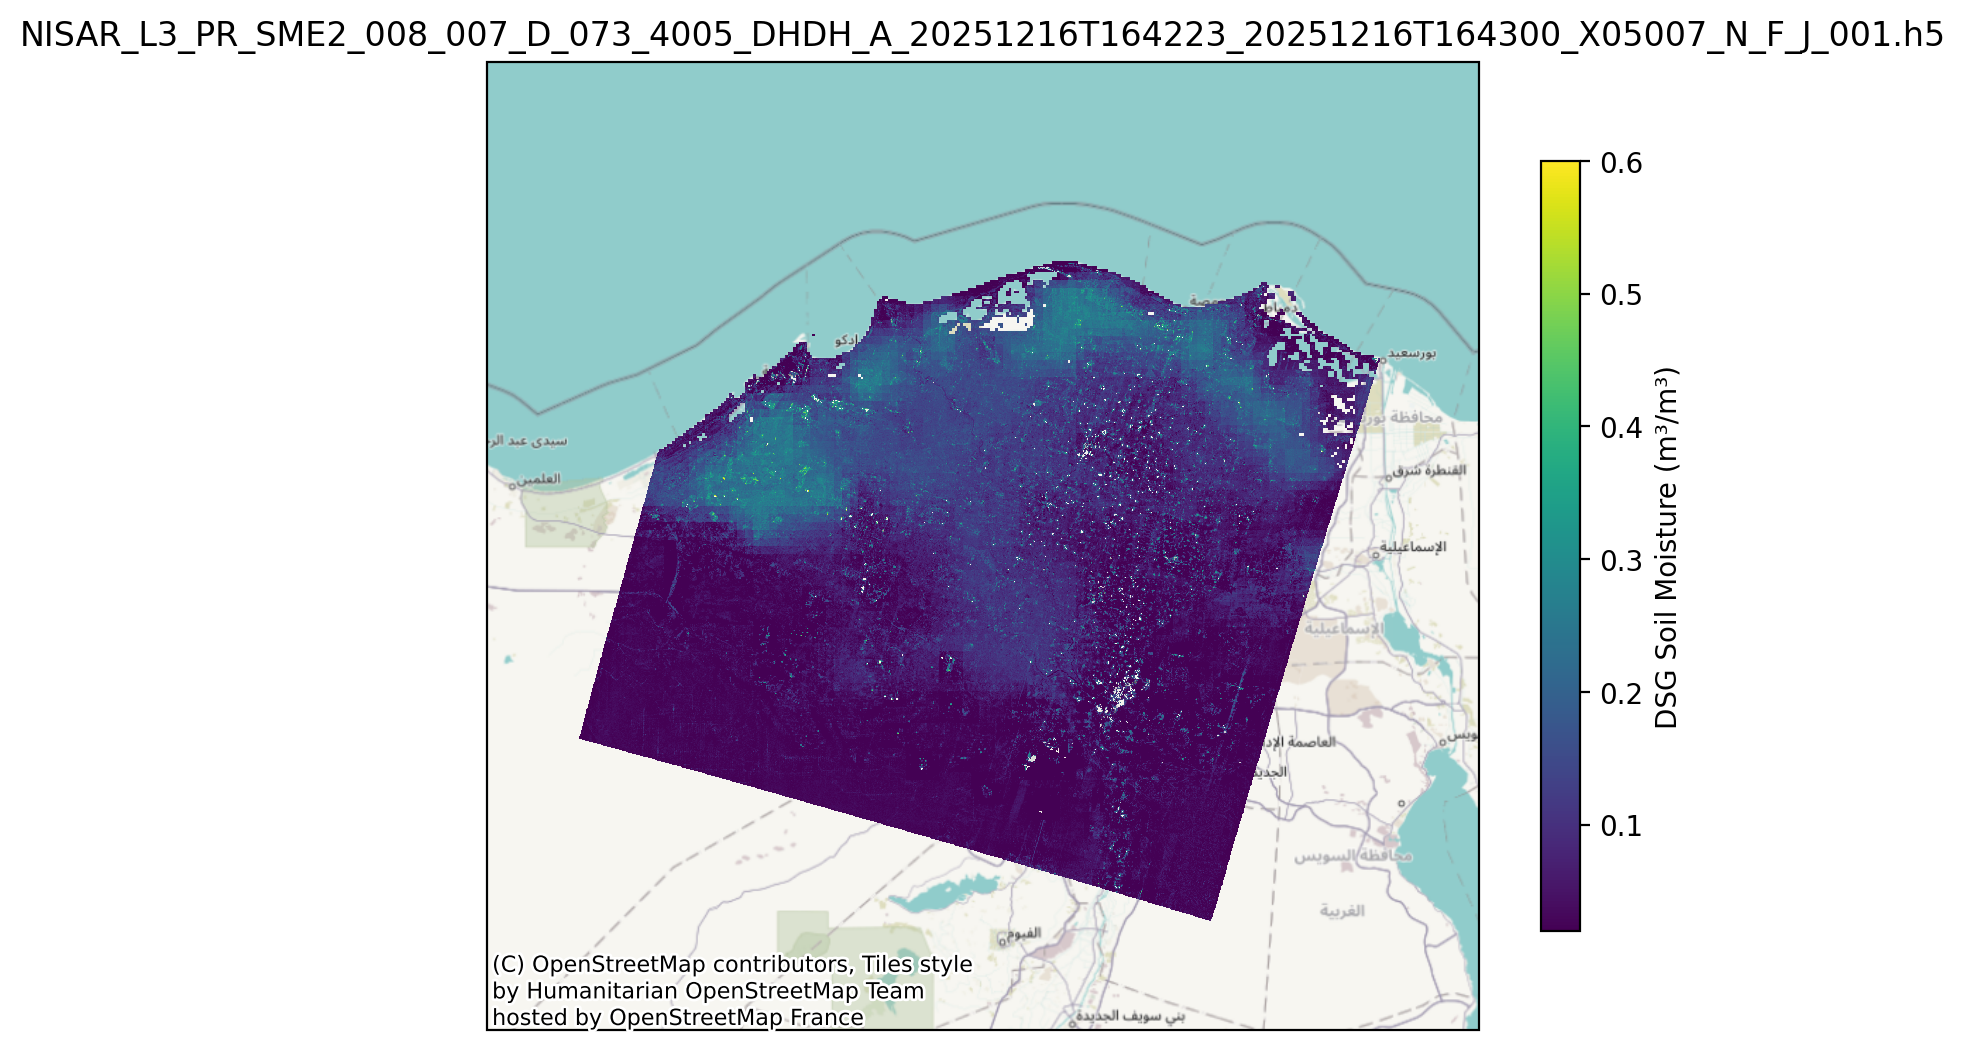

In [ ]:
# Fancier plot
import cartopy.crs as ccrs
import contextily as ctx

# Match plot projection to data
fig,ax = plt.subplots(figsize=(8, 10),
                      subplot_kw=dict(projection=ccrs.epsg(da.rio.crs.to_epsg())),
)

da.plot.imshow(ax=ax,
               cbar_kwargs=dict(shrink=0.5, label=f'{algorithm} Soil Moisture (m³/m³)')
               )

# I recommend contextily for these sorts of plots to make sure you're approximately well-geocoded.
ctx.add_basemap(ax,
               crs=da.rio.crs,
               #source=ctx.providers.Esri.WorldTerrain,
               #source=ctx.providers.Esri.WorldImagery,
               #source=ctx.providers.NASAGIBS.ASTER_GDEM_Greyscale_Shaded_Relief,
               zorder=-1)

plt.title(filename);

In [14]:
# Save as Cloud-optimized GeoTIFF
output_filename = filename.replace('.h5', f'_{algorithm}.tif')
da.rio.to_raster(output_filename, driver='COG', compress='DEFLATE')

## Cloud bucket authentication 

Our bucket allows anonymous read access, but you need credentials to write to it. The below code assumes you have an `~/.aws/credentials` file with the proper credentials and have an `AWS_PROFILE` environment set using that "profile" (`export AWS_PROFILE=cresst-user`):

```
[cresst-user]
aws_access_key_id=AKIAXXXXXXXXXXXXXX
aws_secret_access_key=MTXXXXXXXXXXXXXXXXXXXXXXX
```

In [ ]:
from obstore.auth.boto3 import Boto3CredentialProvider
from obstore.store import S3Store
import os
print(f'Using AWS PROFILE: {os.environ["AWS_PROFILE"]}')

store = S3Store(
    "cresst",
    credential_provider=Boto3CredentialProvider(),
    region="us-west-2",
)
# Recursive listing of everything
#[x['path'] for x in store.list().collect()]

Using AWS PROFILE: cresst-user


['README.md',
 'abdullah/README.md',
 'scottsfiles/NISAR_L3_PR_SME2_008_007_D_073_4005_DHDH_A_20251216T164223_20251216T164300_X05007_N_F_J_001_DSG.tif',
 'stehekin/planet/stehekin-separate_psscene_analytic_sr_udm2/PSScene/20251201_193057_90_24e9.json',
 'stehekin/planet/stehekin-separate_psscene_analytic_sr_udm2/PSScene/20251201_193057_90_24e9_3B_AnalyticMS_SR_harmonized_clip_file_format.tif',
 'stehekin/planet/stehekin-separate_psscene_analytic_sr_udm2/PSScene/20251201_193057_90_24e9_3B_AnalyticMS_metadata_clip.xml',
 'stehekin/planet/stehekin-separate_psscene_analytic_sr_udm2/PSScene/20251201_193057_90_24e9_3B_udm2_clip_file_format.tif',
 'stehekin/planet/stehekin-separate_psscene_analytic_sr_udm2/PSScene/20251201_193057_90_24e9_metadata.json',
 'stehekin/planet/stehekin-separate_psscene_analytic_sr_udm2/PSScene/20251201_193100_18_24e9.json',
 'stehekin/planet/stehekin-separate_psscene_analytic_sr_udm2/PSScene/20251201_193100_18_24e9_3B_AnalyticMS_SR_harmonized_clip_file_format.tif',

In [23]:
# Upload local geotiff to S3
# Careful, this will overwrite exiting paths!
remote_path = f'scottsfiles/{output_filename}'
with open(output_filename, "rb") as content:
    obstore.put(store, remote_path, content)

In [24]:
# Check that it's there
obstore.list(store, "scottsfiles/").collect()

[{'path': 'scottsfiles/NISAR_L3_PR_SME2_008_007_D_073_4005_DHDH_A_20251216T164223_20251216T164300_X05007_N_F_J_001_DSG.tif',
  'last_modified': datetime.datetime(2026, 1, 26, 20, 52, 23, tzinfo=datetime.timezone.utc),
  'size': 4958542,
  'e_tag': '"ef4d567d675a84c72225c11da440dca8"',
  'version': None}]

In [29]:
# Next time, if your software allows, read directly from S3!
da = xr.open_dataarray(f's3://cresst/{remote_path}', engine='rasterio').squeeze()
da

<xarray.DataArray 'band_data' (y: 1800, x: 1845)> Size: 13MB
[3321000 values with dtype=float32]
Coordinates:
  * y            (y) float64 14kB 3.909e+06 3.909e+06 ... 3.549e+06 3.549e+06
  * x            (x) float64 15kB 2.784e+06 2.784e+06 ... 3.153e+06 3.153e+06
    band         int64 8B 1
    spatial_ref  int64 8B ...
Attributes: (12/38)
    /science/LSAR/SME2/grids/algorithmCandidates/DSG/projection#description: ...
    /science/LSAR/SME2/grids/algorithmCandidates/DSG/projection#ellipsoid:   ...
    /science/LSAR/SME2/grids/algorithmCandidates/DSG/projection#epsg_code:   ...
    /science/LSAR/SME2/grids/algorithmCandidates/DSG/projection#false_easting...
    /science/LSAR/SME2/grids/algorithmCandidates/DSG/projection#false_northin...
    /science/LSAR/SME2/grids/algorithmCandidates/DSG/projection#grid_mapping_...
    ...                                                                                          ...
    mean_value:                                                              ...
    min_value:                                                               ...
    sample_stddev:                                                           ...
    units:                                                                   ...
    AREA_OR_POINT:                                                           ...
    long_name:                                                               ...